# Generate Dataframe of Incident Status Information

pwd

In [1]:
cd ..

e:\two_stage_model\data_processing


In [2]:
import geopandas as gpd
import pandas as pd
import pickle
import datetime
import numpy as np
import glob
import os

from datetime import datetime as dt
from shapely.geometry import Point
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from bisect import bisect_left

In [3]:
country_name = 'Cranberry'
model_path = 'E:/two_stage_model'
# Hyperparamter
# Time
start_date = dt(2022, 2, 1)
end_date = dt(2024, 1, 31)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates
datetime_index = pd.bdate_range(start=start_date, end=end_date+datetime.timedelta(days=1),freq="5min")
upstream_range_mile = 0.3
downstream_range_mile = 1
minimum_abnormal_sd_length = 3 # every 5 min, meaning larger than 15 min regard as incident

In [4]:
len(busi_date)

522

# 1. Merage Data into one csv file
### Attention! Only Excute this block if {country_name}_df_inc_raw.pkl is not in this folder

In [4]:
merged_inc_dfs = []

In [5]:
incident_files = glob.glob(f'{model_path}/data/{country_name}/incident_raw' + '/*.csv')

In [6]:
for file_path in incident_files:
    single_inc_df = pd.read_csv(file_path)
    merged_inc_dfs.append(single_inc_df)

In [7]:
merged_inc_df_raw = pd.concat(merged_inc_dfs, axis=0)

In [8]:
merged_inc_df_raw

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Agency-specific Sub Type,Start time,Closed time,Open/Closed,Location,...,Duration (Incident clearance time),Operator Notes,Notifications Sent,Responders,DMS Used,Vehicles Involved,Max Lanes Closed,Reliability Score,Confidence Score,User Report Rating
0,WAZE_f10ba73d-9b85-4449-87d4-d1bb38a12c1f,Waze,Waze,Construction Work,Weatherhazard,Hazard On Road Construction,2022-02-01T09:36:03-05:00,2022-02-01T10:09:42-05:00,Closed,27TH ST,...,33 minutes,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,5.0
1,WAZE_4a6840d4-c114-484f-96a1-09e5a513c995,Waze,Waze,Construction Work,Weatherhazard,Hazard On Road Construction,2022-02-01T09:00:15-05:00,2022-02-01T09:41:21-05:00,Closed,ONE WILD,...,41 minutes,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,5.0
2,WAZE_6fd4a8f5-db51-4763-9855-4afa199b970e,Waze,Waze,Congestion Due to Closure,Road Closed,Road Closed Construction,2022-02-01T17:15:28-05:00,2022-02-01T18:18:43-05:00,Closed,SECOND AVE,...,1 hour 3 minutes,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,4.0
3,WAZE_75bdbe65-af9b-4dc2-813c-d98447cd5624,Waze,Waze,Incident,Accident,NaN,2022-02-01T12:02:27-05:00,2022-02-01T12:35:51-05:00,Closed,5TH AVE,...,33 minutes,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,4.0
4,WAZE_5e96ea64-19a6-4408-acef-c0eb0c8e5347,Waze,Waze,Construction Work,Weatherhazard,Hazard On Road Construction,2022-02-01T09:50:46-05:00,2022-02-01T10:22:33-05:00,Closed,RODI RD,...,31 minutes,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32657,HERE_c50565ab-3123-42e7-8b38-b37d43d124eb,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T08:34:40-05:00,2024-01-19T09:04:40-05:00,Closed,Unknown Location,...,30 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32658,HERE_8cb1a878-5862-4392-8d2e-f4b6cffbc8eb,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T11:32:48-05:00,2024-01-19T12:02:48-05:00,Closed,Unknown Location,...,30 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32659,HERE_a1b66bbf-1305-4acd-ac67-cdefce84ced9,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T17:13:05-05:00,2024-01-19T17:43:05-05:00,Closed,Unknown Location,...,30 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32660,HERE_c9072a34-e101-4071-84b3-2a1b3f0f840a,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T06:35:51-05:00,2024-01-19T07:05:51-05:00,Closed,Unknown Location,...,30 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print('Incident Type Includes', list(set(merged_inc_df_raw['Standardized Type'])))
print('Agency-specific Type Includes', list(set(merged_inc_df_raw['Agency-specific Type'])))
print('Agency-specific Sub Type Includes', list(set(merged_inc_df_raw['Agency-specific Sub Type'])))
print('Incident Source Includes', list(set(merged_inc_df_raw['System'])))
print('Column Includes', list(set(merged_inc_df_raw.columns)))
print('Country Includes', list(set(merged_inc_df_raw['County'])))

Incident Type Includes ['Incident', 'Congestion Due to Closure', 'Icy Conditions', 'Rain', 'Foggy Conditions', 'Animal Struck', 'Congestion', 'Obstructions', 'Construction Work', 'Flood', 'Obstruction due to Animals On Roadway', 'Traffic Signal Not Working', 'Winter Road Report', 'Special Event', 'Collision', 'Weather Condition']
Agency-specific Type Includes ['Fog Event', 'Rain Event', 'Weatherhazard', 'Vehicle Fire', 'Downed Tree', 'Slippery Road Event', 'Hazard', 'Flooding', 'Accident Event', 'Road Closed', 'Winter Weather', 'Accident', 'Special Event', 'Crash', 'Multi Vehicle Crash']
Agency-specific Sub Type Includes ['Hazard On Road Construction', 'Accident Minor', 'Hazard On Road Traffic Light Fault', 'Hazard On Road Object', 'Hazard On Road', 'Hazard Weather Heavy Rain', 'Hazard Weather Heavy Snow', 'Road Closed Construction', 'Hazard On Road Lane Closed', 'Road Closed Hazard', 'Road Closed Event', 'Hazard Weather Hail', 'Accident Major', 'Hazard On Shoulder Animals', 'Hazard On

In [24]:
PeenDOT_Incidents = merged_inc_df_raw[merged_inc_df_raw['System'] == 'PennDOT'].dropna(axis=1, how='all')

In [25]:
PeenDOT_Incidents 

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Start time,Closed time,Open/Closed,Location,Op. Center,...,Road,Direction,County,State,EDC Incident Type,Roadway Clearance Time,Duration (Incident clearance time),dt_start,dt_end,dt_duration
2286,PADOT_647575,PennDOT,PADOT,Incident,Crash,2022-02-04T00:15:00-05:00,2022-02-04T01:33:00-05:00,Closed,Mile Post: 3.5,Unknown,...,NaN,South,Allegheny,Pennsylvania,other,1 hour 18 minutes,1 hour 18 minutes,2022-02-04 00:15:00,2022-02-04 01:33:00,0 days 01:18:00
2287,PADOT_647455,PennDOT,PADOT,Congestion,Winter Weather,2022-02-03T11:35:53-05:00,2022-02-04T15:17:00-05:00,Closed,PA - 028 between (Beginning of PA - 028) and E...,Unknown,...,PA 28,West,Allegheny,Pennsylvania,other,1 days 3 hours 41 minutes,1 days 3 hours 41 minutes,2022-02-03 11:35:53,2022-02-04 15:17:00,1 days 03:41:07
2288,PADOT_649874,PennDOT,PADOT,Obstructions,Flooding,2022-02-18T01:04:00-05:00,2022-02-18T14:14:00-05:00,Closed,"PA - 038 between Intersection of HOON RD, PINE...",Unknown,...,PA 38,Bi-directional,Butler,Pennsylvania,other,13 hours 10 minutes,13 hours 10 minutes,2022-02-18 01:04:00,2022-02-18 14:14:00,0 days 13:10:00
2289,PADOT_649876,PennDOT,PADOT,Obstructions,Flooding,2022-02-18T01:26:00-05:00,2022-02-18T20:37:00-05:00,Closed,SERVICE CREEK RD between Intersection of CLEAR...,Unknown,...,SERVICE CREEK RD,Bi-directional,Beaver,Pennsylvania,other,19 hours 11 minutes,19 hours 11 minutes,2022-02-18 01:26:00,2022-02-18 20:37:00,0 days 19:11:00
2290,PADOT_651398,PennDOT,PADOT,Incident,Multi Vehicle Crash,2022-02-27T16:14:00-05:00,2022-02-27T16:18:00-05:00,Closed,I - 376 between Exit: US 19 NORTH/PA 51 NORTH ...,Unknown,...,I-376,North,Allegheny,Pennsylvania,other,4 minutes,4 minutes,2022-02-27 16:14:00,2022-02-27 16:18:00,0 days 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24905,PADOT_797267,PennDOT,PADOT,Incident,Crash,2024-01-24T10:42:00-05:00,2024-01-24T11:00:00-05:00,Closed,Exit: CARNEGIE { # 57 },Unknown,...,NaN,South,Allegheny,Pennsylvania,other,18 minutes,18 minutes,2024-01-24 10:42:00,2024-01-24 11:00:00,0 days 00:18:00
24906,PADOT_797388,PennDOT,PADOT,Incident,Multi Vehicle Crash,2024-01-25T09:04:00-05:00,2024-01-25T09:56:00-05:00,Closed,Mile Post: 6.0,Unknown,...,NaN,South,Allegheny,Pennsylvania,other,52 minutes,52 minutes,2024-01-25 09:04:00,2024-01-25 09:56:00,0 days 00:52:00
24907,PADOT_796177,PennDOT,PADOT,Incident,Crash,2024-01-17T20:07:00-05:00,2024-01-17T20:24:00-05:00,Closed,Intersection of WEST ACCESS RD in PITTSBURGH [...,Unknown,...,INTERSECTION,North,Allegheny,Pennsylvania,other,17 minutes,17 minutes,2024-01-17 20:07:00,2024-01-17 20:24:00,0 days 00:17:00
24908,PADOT_797024,PennDOT,PADOT,Congestion,Winter Weather,2024-01-23T05:50:38-05:00,2024-01-23T07:52:00-05:00,Closed,I - 376 between Exit: I-79 SOUTH - WASHINGTON ...,Unknown,...,I-376,South,Allegheny,Pennsylvania,other,2 hours 1 minute,2 hours 1 minute,2024-01-23 05:50:38,2024-01-23 07:52:00,0 days 02:01:22


In [10]:
PeenDOT_Incidents.columns

NameError: name 'PeenDOT_Incidents' is not defined

In [27]:
PeenDOT_Incidents['Detection Source']

2286     unknown
2287     unknown
2288     unknown
2289     unknown
2290     unknown
          ...   
24905    unknown
24906    unknown
24907    unknown
24908    unknown
24909    unknown
Name: Detection Source, Length: 5768, dtype: object

In [ ]:
PeenDOT_Incidents.to_csv('Cranberry_PeenDOT_Incidents.csv', index=False)

In [11]:
pickle.dump(merged_inc_df_raw, open(f'{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl', "wb"))

# 2. Load Geo and Speed Information

 - load geo information

In [12]:
gdf_tmc_raw = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc_raw = gdf_tmc_raw.rename(columns={"tmc":"id_tmc"})

In [13]:
spd_record_all = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))

In [14]:
speed_available_tmc_list = list(spd_record_all.columns)

In [15]:
gdf_tmc_all = gdf_tmc_raw[gdf_tmc_raw['id_tmc'].isin(speed_available_tmc_list)]

In [16]:
gdf_tmc_all_polygon = gdf_tmc_raw.copy()  #gdf_tmc_all.copy()
gdf_tmc_all_polygon["geometry"] = gdf_tmc_raw.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326) #gdf_tmc_all.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

# 3 Process Incident Dataframe
 - load incident information

In [17]:
merged_inc_df_raw = pickle.load(open(f"{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl", "rb")) 

## 3.1 Clean Date and Time

In [18]:
merged_inc_df_raw = merged_inc_df_raw[~((merged_inc_df_raw["Closed time"].isna()) & (merged_inc_df_raw["Duration (Incident clearance time)"].isna()))] 

In [19]:
merged_inc_df_raw["dt_start"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Start time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_end"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Closed time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_duration"] = merged_inc_df_raw["dt_end"] - merged_inc_df_raw["dt_start"]

## 3.2 Perform spatial join to map incident location to TMC segment(s)

In [20]:
# Note: gpd.GeoDataFrame() is inplace, so I supply TSMO_df_inc_raw.copy() here
gdf_inc_point = gpd.GeoDataFrame(
                    merged_inc_df_raw.copy(), crs={'init': 'epsg:4326'},
                    geometry=[Point(xy) for xy in zip(merged_inc_df_raw["Longitude"], merged_inc_df_raw["Latitude"])]) # (163140, 34)

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [21]:
gdf_inc_point = gdf_inc_point[~((gdf_inc_point.Latitude.isna()) | (gdf_inc_point.Longitude.isna()))] # (163139, 34)

<Axes: >

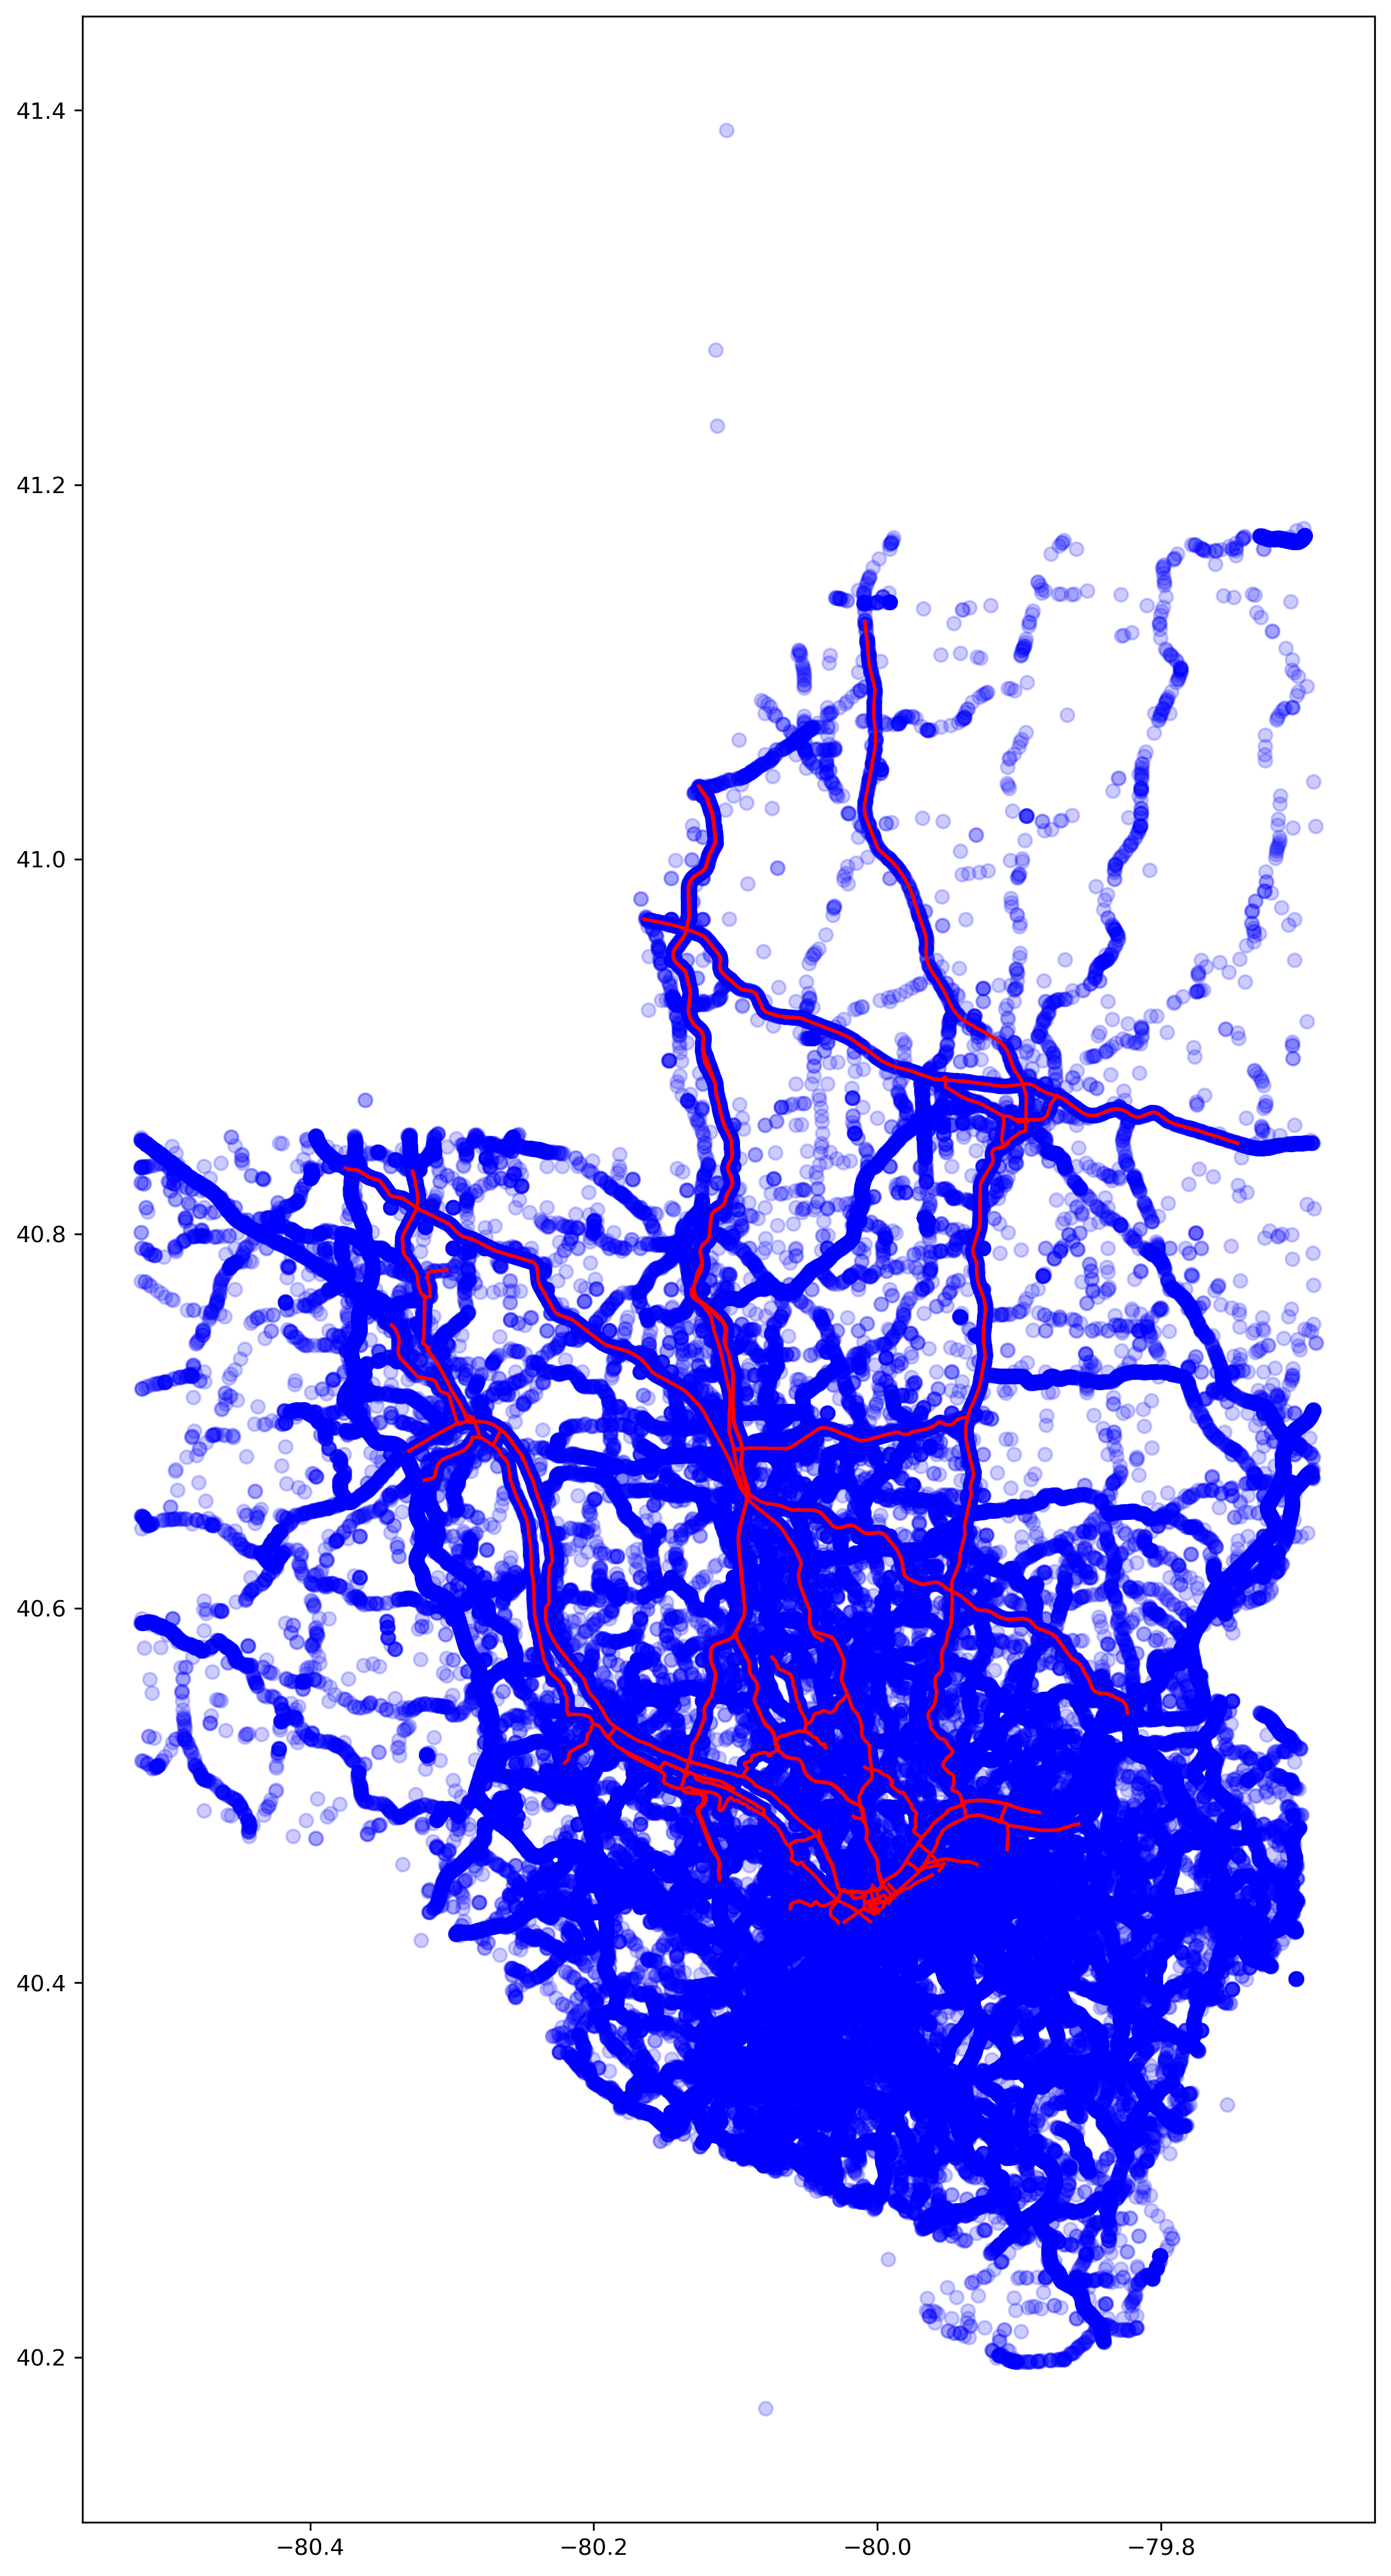

In [22]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_inc_point.plot(ax=ax, color="blue", alpha=0.2)
gdf_tmc_raw.plot(ax=ax, color = "red") #gdf_tmc_all.plot(ax=ax, color = "red")

In [23]:
gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_all_polygon, how="left", op="within")  

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\haowu\AppData\Local\Temp\ipykernel_944660\1596107103.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_all_polygon, how="left", op="within")


In [24]:
gdf_inc_record_all_raw = gdf_inc_point_matched_with_tmc[~gdf_inc_point_matched_with_tmc.id_tmc.isna()]  

In [26]:
gdf_inc_record_all_raw

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Agency-specific Sub Type,Start time,Closed time,Open/Closed,Location,...,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,95.000,GREEN BELT,PA-8,ALLEGHENY,PA,15206,40.48691,-79.91596,40.48557,-79.91073
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,1.000,NaN,NaN,ALLEGHENY,PA,15206,40.48659,-79.91324,40.48637,-79.91383
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,1.000,NaN,NaN,ALLEGHENY,PA,15206,40.48691,-79.91596,40.48659,-79.91324
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,10.000,GREEN BELT,PA-8,ALLEGHENY,PA,15206,40.48557,-79.91073,40.48691,-79.91596
12,WAZE_0046ed2e-d542-467f-805d-11cf0b6b5485,Waze,Waze,Construction Work,Weatherhazard,Hazard On Road Construction,2022-02-01T15:15:29-05:00,2022-02-01T16:41:35-05:00,Closed,I-76,...,12.000,I-76 E,I-76,BUTLER,PA,16066,40.71943,-80.14320,40.68157,-80.10582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32612,HERE_6bd34771-2a98-4636-9a34-b0f0e0c60eb6,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T21:50:46-05:00,2024-01-19T22:20:46-05:00,Closed,Unknown Location,...,1.000,10TH ST BYP,NaN,ALLEGHENY,PA,15222,40.44388,-80.00437,40.44654,-79.99457
32614,HERE_4e0fbfb3-43a8-4f7f-9068-5ace065df530,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T08:31:17-05:00,2024-01-19T09:01:17-05:00,Closed,Unknown Location,...,7.500,FORBES AVE,NaN,ALLEGHENY,PA,15222,40.43866,-79.99723,40.44079,-80.00293
32626,HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T19:31:32-05:00,2024-01-19T20:01:32-05:00,Closed,Unknown Location,...,66.001,PA-51,US-19,ALLEGHENY,PA,15220,40.44364,-80.02866,40.44161,-80.03072
32626,HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T19:31:32-05:00,2024-01-19T20:01:32-05:00,Closed,Unknown Location,...,691.000,PA-51,US-19,ALLEGHENY,PA,15220,40.44161,-80.03072,40.44364,-80.02866


## 3.3. Finalize Spatial-temporal Dataframe of Incident Status
-Make spatial-temporal dataframe of incident status

In [27]:
# Make sure start and/or end date falls into business dates
gdf_inc_record_all_filtered_date = gdf_inc_record_all_raw[
    (gdf_inc_record_all_raw.dt_start.dt.date.isin(busi_date)) | (gdf_inc_record_all_raw.dt_end.dt.date.isin(busi_date))
    ]  # (29800, 52)


# Make sure start and/or end time falls into business hours
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date[
                ((gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_start.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 +gdf_inc_record_all_filtered_date.dt_start.dt.minute < end_time)) |
                ((gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute < end_time)) 
            ]  # (26984, 52)

In [28]:
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date_time[gdf_inc_record_all_filtered_date_time.dt_start.dt.date == gdf_inc_record_all_filtered_date_time.dt_end.dt.date]

In [29]:
gdf_inc_record_all_filtered_date_time

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Agency-specific Sub Type,Start time,Closed time,Open/Closed,Location,...,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,95.000,GREEN BELT,PA-8,ALLEGHENY,PA,15206,40.48691,-79.91596,40.48557,-79.91073
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,1.000,NaN,NaN,ALLEGHENY,PA,15206,40.48659,-79.91324,40.48637,-79.91383
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,1.000,NaN,NaN,ALLEGHENY,PA,15206,40.48691,-79.91596,40.48659,-79.91324
9,WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1,Waze,Waze,Obstructions,Weatherhazard,Hazard On Road Pot Hole,2022-02-01T05:15:13-05:00,2022-02-01T09:20:20-05:00,Closed,SR-28,...,10.000,GREEN BELT,PA-8,ALLEGHENY,PA,15206,40.48557,-79.91073,40.48691,-79.91596
12,WAZE_0046ed2e-d542-467f-805d-11cf0b6b5485,Waze,Waze,Construction Work,Weatherhazard,Hazard On Road Construction,2022-02-01T15:15:29-05:00,2022-02-01T16:41:35-05:00,Closed,I-76,...,12.000,I-76 E,I-76,BUTLER,PA,16066,40.71943,-80.14320,40.68157,-80.10582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32600,HERE_a5a0882f-fa29-494c-9334-e0efb25bd3d3,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T14:46:38-05:00,2024-01-19T15:16:38-05:00,Closed,Unknown Location,...,15.500,I-76 E,I-76,ALLEGHENY,PA,15044,40.64296,-80.02806,40.63032,-79.98565
32614,HERE_4e0fbfb3-43a8-4f7f-9068-5ace065df530,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T08:31:17-05:00,2024-01-19T09:01:17-05:00,Closed,Unknown Location,...,7.500,FORBES AVE,NaN,ALLEGHENY,PA,15222,40.43866,-79.99723,40.44079,-80.00293
32626,HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T19:31:32-05:00,2024-01-19T20:01:32-05:00,Closed,Unknown Location,...,66.001,PA-51,US-19,ALLEGHENY,PA,15220,40.44364,-80.02866,40.44161,-80.03072
32626,HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33,HERE Hazard Warnings,HERE,Weather Condition,Slippery Road Event,NaN,2024-01-19T19:31:32-05:00,2024-01-19T20:01:32-05:00,Closed,Unknown Location,...,691.000,PA-51,US-19,ALLEGHENY,PA,15220,40.44161,-80.03072,40.44364,-80.02866


In [30]:
pickle.dump(gdf_inc_record_all_filtered_date_time, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_raw_waze_inc_eval.pkl", "wb"))

In [31]:
df_inc = pd.DataFrame(data=0.0,index=datetime_index,columns=list(set(gdf_tmc_raw.id_tmc))) 

In [32]:
df_inc = df_inc[
        (pd.to_datetime(df_inc.index.date).isin(busi_date)) &   # be careful about the syntax here, dealing with index filtering is really annoying
        (df_inc.index.hour*60 + df_inc.index.minute >= start_time) &
        (df_inc.index.hour*60 + df_inc.index.minute < end_time) 
    ] 

In [33]:
df_inc

,104N06177,104-09220,104-04540,104+08083,104P50448,104P04550,104-06359,104N13495,104-09226,104N08971,...,104P50425,104+13495,104N09243,104+08982,104+04713,104N04520,104N08941,104-50425,104P50583,104P51422
2022-02-01 05:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 20:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def earliest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.min()

In [35]:
def find_earlier_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if time_list[position-1].date()!=query_time.date():
        return earliest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
    else:
        return time_list[position-1] # if position else None

In [36]:
def latest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.max()

In [37]:
def find_later_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if position < len(time_list):
        if time_list[position].date()!=query_time.date():
            return latest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
        else:
            return time_list[position]  
    else:
        return max(time_list)

In [38]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc

    # print(find_later_time(df_inc.index, end), end)
    if find_earlier_time(df_inc.index, start).date() != start.date() or find_later_time(df_inc.index, end).date() != end.date() or find_later_time(df_inc.index, end).date() != find_earlier_time(df_inc.index, start).date():
        print(gdf_inc_record_all_filtered_date_time.iloc[i])

  0%|          | 0/85941 [00:00<?, ?it/s]

100%|██████████| 85941/85941 [02:53<00:00, 495.13it/s] 


In [39]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc
    # df_inc_waze[(df_inc_waze.index >= start) & (df_inc_waze.index < end)][id_tmc] = 1.0 # this won't work as it will return a view instead of changing value in place
    df_inc.loc[find_earlier_time(df_inc.index, start): find_later_time(df_inc.index, end), id_tmc] = 1.0
    if i == 0: # demo the incident labelling rule
        print('report starts at', start)
        print('we start labelling at', find_earlier_time(df_inc.index, start))
        print('report ends at', end)
        print('we end labelling at', find_later_time(df_inc.index, end))

  0%|          | 90/85941 [00:00<03:03, 467.83it/s]

report starts at 2022-02-01 05:15:13
we start labelling at 2022-02-01 05:30:00
report ends at 2022-02-01 09:20:20
we end labelling at 2022-02-01 09:25:00


100%|██████████| 85941/85941 [01:46<00:00, 808.52it/s] 


In [40]:
df_inc

,104N06177,104-09220,104-04540,104+08083,104P50448,104P04550,104-06359,104N13495,104-09226,104N08971,...,104P50425,104+13495,104N09243,104+08982,104+04713,104N04520,104N08941,104-50425,104P50583,104P51422
2022-02-01 05:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-01 05:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-31 20:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
np.count_nonzero(df_inc) # 101123 for TSMO

1300525

In [42]:
pickle.dump(df_inc, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_raw_Waze.pkl", "wb"))